In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import cdecimal as dec
import re as re
import csv
import os, sys

weather_path = 'C:\Users\Zghiru\Documents\GitHub\RC_BuildingSimulator\Justin_Semseter_Project\data\Zurich-Kloten_2013.epw'
occupancy_path = 'C:\Users\Zghiru\Documents\GitHub\RC_BuildingSimulator\Justin_Semseter_Project\data\Occupancy_COM.csv'
radiation_path = r'C:\Users\Zghiru\Documents\GitHub\RC_BuildingSimulator\Justin_Semseter_Project\data\radiation_Building_Zh.csv'
archetypes_properties_path = "C:\Users\Zghiru\Documents\GitHub\RC_BuildingSimulator\Justin_Semseter_Project\data\CH\Archetypes\Archetypes_properties.xlsx"
archetypes_schedules_path = "C:\Users\Zghiru\Documents\GitHub\RC_BuildingSimulator\Justin_Semseter_Project\data\CH\Archetypes\Archetypes_schedules.xlsx"
occ_path = 'C:\Users\Zghiru\Documents\GitHub\RC_BuildingSimulator\Justin_Semseter_Project\schedules_occ.csv'

Definitions for generating occupancy and lighting schedules imported directly from the CEA repository (https://github.com/architecture-building-systems/CEAforArcGIS)

Referred to in folder as j_schedulemaker.py

In [2]:
"""
===========================
Query schedules according to database
===========================
J. Fonseca  script development          26.08.2015
D. Thomas   documentation               10.08.2016
"""

from __future__ import division
import pandas as pd
import numpy as np

__author__ = "Jimeno A. Fonseca"
__copyright__ = "Copyright 2015, Architecture and Building Systems - ETH Zurich"
__credits__ = ["Jimeno A. Fonseca"]
__license__ = "MIT"
__version__ = "0.1"
__maintainer__ = "Daren Thomas"
__email__ = "thomas@arch.ethz.ch"
__status__ = "Production"

"""
=========================================
Occupancy
=========================================
"""

def schedule_maker(dates, list_uses):
    def get_yearly_vectors(dates, occ_schedules, el_schedules, dhw_schedules, pro_schedules, month_schedule):
        occ = []
        el = []
        dhw = []
        pro = []

        if dhw_schedules[0].sum() != 0:
            dhw_weekday_sum = dhw_schedules[0].sum() ** -1
        else: dhw_weekday_sum = 0

        if dhw_schedules[1].sum() != 0:
            dhw_sat_sum = dhw_schedules[1].sum() ** -1
        else: dhw_sat_sum = 0

        if dhw_schedules[2].sum() != 0:
            dhw_sun_sum = dhw_schedules[2].sum() ** -1
        else: dhw_sun_sum = 0

        for date in dates:
            month_year = month_schedule[date.month - 1]
            hour_day = date.hour
            dayofweek = date.dayofweek
            if 0 <= dayofweek < 5:  # weekday
                occ.append(occ_schedules[0][hour_day] * month_year)
                el.append(el_schedules[0][hour_day] * month_year)
                dhw.append(dhw_schedules[0][hour_day] * month_year * dhw_weekday_sum) # normalized dhw demand flow rates
                pro.append(pro_schedules[0][hour_day] * month_year)
            elif dayofweek is 5:  # saturday
                occ.append(occ_schedules[1][hour_day] * month_year)
                el.append(el_schedules[1][hour_day] * month_year)
                dhw.append(dhw_schedules[1][hour_day] * month_year * dhw_sat_sum) # normalized dhw demand flow rates
                pro.append(pro_schedules[1][hour_day] * month_year)
            else:  # sunday
                occ.append(occ_schedules[2][hour_day] * month_year)
                el.append(el_schedules[2][hour_day] * month_year)
                dhw.append(dhw_schedules[2][hour_day] * month_year * dhw_sun_sum) # normalized dhw demand flow rates
                pro.append(pro_schedules[2][hour_day] * month_year)

        return occ, el, dhw, pro

    schedules = []
    for use in list_uses:
        # Read from archetypes_schedules
        x = pd.read_excel(archetypes_schedules_path, use).T

        # read lists of every daily profile
        occ_schedules, el_schedules, dhw_schedules, pro_schedules, month_schedule = read_schedules(use, x)

        schedule = get_yearly_vectors(dates, occ_schedules, el_schedules, dhw_schedules, pro_schedules, month_schedule)
        schedules.append(schedule)

    return schedules

def read_schedules(use, x):
    occ = [x['Weekday_1'].values, x['Saturday_1'].values, x['Sunday_1'].values]
    el = [x['Weekday_2'].values, x['Saturday_2'].values, x['Sunday_2'].values]
    dhw = [x['Weekday_3'].values, x['Saturday_3'].values, x['Sunday_3'].values]
    month = x['month'].values

    if use is "INDUSTRIAL":
        pro = [x['Weekday_4'].values, x['Saturday_4'].values, x['Sunday_4'].values]
    else:
        pro = [np.zeros(24), np.zeros(24), np.zeros(24)]

    return [occ,el,dhw,pro,month]

In [3]:
#Set Building Parameters in [mm]
BuildingData={  
"room_width": 4900,     
"room_height":3100,
"room_depth":7000,
"glazing_percentage_w": 0.92,
"glazing_percentage_h": 0.97}

#################################################################---NEW
#Set building properties for RC-Model simulator
BuildingProperties={
"glass_solar_transmitance" : 0.687 ,
"glass_light_transmitance" : 0.744 ,
"lighting_load" : 11.74 ,
"lighting_control" : 300,
"Lighting_Utilisation_Factor" :  0.45,
"Lighting_MaintenanceFactor" : 0.9,
"U_em" : 0.2, 
"U_w" : 1.2,
"ACH_vent" : 1.5,
"ACH_infl" :0.5,
"ventilation_efficiency" : 0.6 ,
"c_m_A_f" : 165 * 10**3,
"theta_int_h_set" : 20,
"theta_int_c_set" : 26,
"phi_c_max_A_f": -np.inf,
    
"phi_h_max_A_f":np.inf,
#"heatingSystem" : DirectHeater, #DirectHeater, #ResistiveHeater #HeatPumpHeater
#"coolingSystem" : DirectCooler, #DirectCooler, #HeatPumpCooler
"heatingEfficiency" : 1,
"coolingEfficiency" :1,
}



#Set simulation Properties
SimulationOptions= {
'setBackTemp' : 4.,
'Occupancy' : 'Occupancy_COM.csv',
'ActuationEnergy' : False}


In [10]:
lighting_ontrol_d ={
"MULTI_RES":250,
"SINGLE_RES":200,
"HOTEL":300,
"OFFICE":350,
"RETAIL":400,
"FOODSTORE":400,
"RESTAURANT":250,
"INDUSTRIAL":300,
"SCHOOL":350,
"HOSPITAL":400,
"GYM":300
    
}

def ArchT_build_df(BuildingData):
    thermal= pd.read_excel(archetypes_properties_path,sheetname='THERMAL')
    r = re.compile("([a-zA-Z_]+)")
    m = r.match(thermal["Code"][1])
    
    thermal["code1"] = pd.DataFrame([r.match(string).groups() for string in thermal.Code])
    thermal= thermal.set_index(['code1'])  
    thermal= thermal.drop(['SERVERROOM','PARKING','SWIMMING','COOLROOM'])
    thermal= thermal.reset_index(drop=False)
    thermal= thermal.drop('Es',axis=1)
    thermal= thermal.drop('Hs',axis=1)
    thermal= thermal.drop('U_roof',axis=1)
    thermal= thermal.drop('U_base',axis=1)
    
    arch = pd.read_excel(archetypes_properties_path,sheetname='ARCHITECTURE')
    arch = arch.set_index(['Code'])
    arch = pd.DataFrame(arch.Occ_m2p)
    arch = arch.reset_index(drop=False)
    
    int_loads = pd.read_excel(archetypes_properties_path,sheetname='INTERNAL_LOADS')
    int_loads = int_loads.set_index(['Code'])
    int_loads = int_loads[['Qs_Wp','Ea_Wm2','El_Wm2']]
    int_loads = int_loads.reset_index(drop=False)

    T_sp = pd.read_excel(archetypes_properties_path,sheetname='INDOOR_COMFORT')

    b_props = thermal.merge(int_loads,how='left', left_on='code1', right_on='Code')
    b_props = b_props.merge(T_sp,how='left', left_on='code1', right_on='Code')
    b_props = b_props.merge(arch,how='left', left_on='Code_x', right_on='Code')
    b_props = b_props.drop('Code_y',axis=1)
    b_props = b_props.drop('Code',axis=1)
    b_props['CoolingSetBackTemp'] = b_props['Tcs_setb_C']-b_props['Tcs_set_C']
    b_props['HeatingSetBackTemp'] = b_props['Ths_set_C']-b_props['Ths_setb_C']
    
    volume = (BuildingData['room_width']/1000)*(BuildingData['room_depth']/1000)*(BuildingData['room_height']/1000)
    area = (BuildingData['room_width']/1000)*(BuildingData['room_depth']/1000)
    
    b_props['ACH'] = b_props['Ve_lps']*3.6/volume
    
    #Assign values for Cm from ISO13790:2008, Table 12, based on archetypes
    th_mass = b_props['th_mass']
    c_m = []
    for i in range(0,len(th_mass)):
        if th_mass[i] == "T1":
            c_m.append(110*10**3) #Light
        elif th_mass[i] == "T2":
            c_m.append(165 * 10**3) #Medium
        elif th_mass[i] == "T3":
            c_m.append(260*10**3) #Heavy
    b_props['c_m_A_f'] = pd.DataFrame(c_m)

#declare variables
    occupancy = []
    lighting_control = []
#declare constants
    glass_solar_transmitance = []
    glass_light_transmitance = []
    Lighting_Utilisation_Factor = []
    Lighting_MaintenanceFactor = [] 
    ACH_infl = [] 
    ventilation_efficiency = [] 
    phi_c_max_A_f = [] 
    phi_h_max_A_f = [] 
    heatingSystem = []  
    coolingSystem = [] 
    heatingEfficiency = []  
    coolingEfficiency = [] 
    ActuationEnergy = []    

    for code in b_props['code1']:
        #variables
        occupancy.append('schedules_occ_%s.csv'%code)
        lighting_control.append(lighting_ontrol_d.get(code))
        
        glass_solar_transmitance.append(0.687)
        glass_light_transmitance.append(0.744)
        Lighting_Utilisation_Factor.append(0.45) 
        Lighting_MaintenanceFactor.append(0.9) 
        ACH_infl.append(0.5) 
        ventilation_efficiency.append(0.6)
        phi_c_max_A_f.append(-np.inf)  
        phi_h_max_A_f.append(np.inf) 
        heatingSystem.append("DirectHeater") #DirectHeater, #ResistiveHeater #HeatPumpHeater
        
        coolingSystem.append("DirectCooler") #DirectCooler, #HeatPumpCooler
        heatingEfficiency.append(1)
        coolingEfficiency.append(1)
        ActuationEnergy.append(False)
        
    b_props['lighting_control'] = lighting_control
    b_props['Occupancy'] = occupancy
    b_props['ActuationEnergy'] = ActuationEnergy  
    
    b_props['glass_solar_transmitance'] = glass_solar_transmitance
    b_props['glass_light_transmitance'] = glass_light_transmitance
    b_props['Lighting_Utilisation_Factor'] = Lighting_Utilisation_Factor
    b_props['Lighting_MaintenanceFactor'] = Lighting_MaintenanceFactor
    b_props['ACH_infl'] = ACH_infl
    b_props['ventilation_efficiency'] = ventilation_efficiency
    b_props['phi_c_max_A_f'] = phi_c_max_A_f
    b_props['phi_h_max_A_f'] = phi_h_max_A_f
    b_props['heatingSystem'] = heatingSystem
    b_props['coolingSystem'] = coolingSystem
    b_props['heatingEfficiency'] = heatingEfficiency
    b_props['coolingEfficiency'] = coolingEfficiency
    
    
    return b_props

# For a different set of buildings, set path and call build_schedules(b_props,path_data) here. I still haven't figured out how to set the correct path using simulationFunctions.py.

#Create dictionaries for Archetypes:
def MakeDicts(b_props):
 
    bp_df = b_props[['Code_x',
                          'El_Wm2',
                          'lighting_control',
                          'U_wall',
                          'U_win',
                          'Ths_set_C',
                          'Tcs_set_C',
                          'ACH',
                          'c_m_A_f',
                          'Qs_Wp',    #[W/p]
                          'Ea_Wm2',    #[W/m2]
                          'glass_solar_transmitance',
                          'glass_light_transmitance',
                          'Lighting_Utilisation_Factor',
                          'Lighting_MaintenanceFactor',
                          'ACH_infl',
                          'ventilation_efficiency',
                          'phi_c_max_A_f',
                          'phi_h_max_A_f',
                          'heatingSystem',
                          'coolingSystem',
                          'heatingEfficiency',
                          'coolingEfficiency']]
    
    bp_df = bp_df.rename(index=str,columns={'Code_x':'Code',
                                                        'El_Wm2':'lighting_load',
                                                        'U_win':'U_w',
                                                        'c_m_A_f':'c_m_A_f',
                                                        'U_wall':'U_em',
                                                        'Ths_set_C':'theta_int_h_set',
                                                        'Tcs_set_C':'theta_int_c_set'})
    bp_df = bp_df.set_index(['Code'])
    BP_dict = bp_df.to_dict(orient='index')

    sd_df = b_props[['Code_x','CoolingSetBackTemp','HeatingSetBackTemp','Occupancy','ActuationEnergy']]
    sd_df = sd_df.set_index(['Code_x'])
    
    SD_dict = sd_df.to_dict(orient='index')       
    return BP_dict, SD_dict
                      
b_props = ArchT_build_df(BuildingData)
BP_dict,SD_dict = MakeDicts(b_props)
#b_props.to_csv('b_props.csv')
b_props = b_props.drop('0',axis=1)
b_props = b_props.drop('code1',axis=1)
b_props = b_props.drop('index',axis=1)
#b_props = b_props[b_props.interval == "2005-2020"]
b_props = b_props.reset_index()

b_props.to_csv('b_props.csv')

#print BP_dict




Additional code to convert schedules into csv files:


In [16]:
def full_date(weather_path,month,day):
    year = pd.read_csv(weather_path, skiprows=8, header=None, names=epw_labels)['year']
    return pd.datetime(year[1],month,day)


start = full_date(weather_path,1,1)
date = pd.date_range(start, periods=8760, freq='H')

ArchT_df = ArchT_build_df(BuildingData)
ArchT_typologies = ArchT_df.code1.unique()

list_uses = ArchT_typologies
schedules = schedule_maker(date, list_uses)
schedules = zip(*schedules)

occ = schedules[0]
el = schedules[1]
dhw = schedules[2]
pro = schedules[3]

occ_df = pd.DataFrame({'0':range(0,8760)})
el_df = pd.DataFrame({'0':range(0,8760)})
dhw_df = pd.DataFrame({'0':range(0,8760)})
pro_df = pd.DataFrame({'0':range(0,8760)})

for i in range(0,len(occ)):
    occ_df[list(list_uses)[i]] = occ[i]
    el_df[list(list_uses)[i]] = el[i]
    dhw_df[list(list_uses)[i]] = dhw[i]
    pro_df[list(list_uses)[i]] = pro[i]

occ_df = occ_df.set_index('0',drop=True)
el_df = el_df.set_index('0',drop=True)
dhw_df = dhw_df.set_index('0',drop=True)
pro_df = pro_df.set_index('0',drop=True)

occ_m2p = ArchT_df.drop_duplicates('code1')
occ_m2p = occ_m2p.set_index('code1')
occ_m2p = occ_m2p.Occ_m2p
occ_m2p = 1/occ_m2p

for column in occ_df:
    occ1 = pd.concat([occ_df[column]],axis=1, keys=['People'])*occ_m2p[column]
    print "%s: %f" %(column,np.mean(occ1))
    #occ1['People'].to_csv('schedules_occ_%s.csv'%column,header=True, index = False)
    el1 =pd.concat([el_df[column]],axis=1, keys=['People'])
    #el1['People'].to_csv('schedules_el_%s.csv'%column, header=True, index = False)


MULTI_RES: 0.014355
SINGLE_RES: 0.009570
HOTEL: 0.034377
OFFICE: 0.009951
RETAIL: 0.033507
FOODSTORE: 0.055845
RESTAURANT: 0.072592
INDUSTRIAL: 0.030994
SCHOOL: 0.010913
HOSPITAL: 0.073750
GYM: 0.070977


============== Justin's RC Model=================

1. data import functions


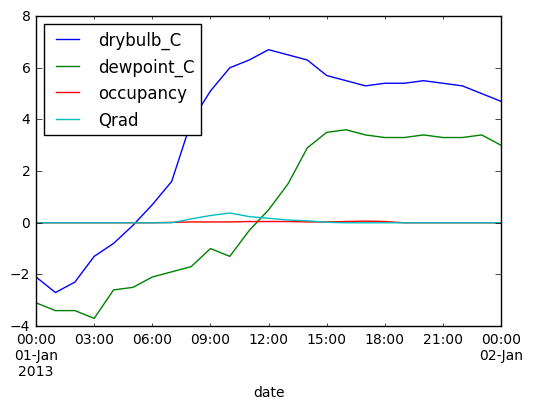

In [9]:
#epw_reader adapted from https://github.com/architecture-building-systems/CEAforArcGIS/blob/master/cea/utilities/epwreader.py

epw_labels = ['year', 'month', 'day', 'hour', 'minute', 'datasource', 'drybulb_C', 'dewpoint_C', 'relhum_percent',
                   'atmos_Pa', 'exthorrad_Whm2', 'extdirrad_Whm2', 'horirsky_Whm2', 'glohorrad_Whm2',
                   'dirnorrad_Whm2', 'difhorrad_Whm2', 'glohorillum_lux', 'dirnorillum_lux','difhorillum_lux',
                   'zenlum_lux', 'winddir_deg', 'windspd_ms', 'totskycvr_tenths', 'opaqskycvr_tenths', 'visibility_km',
                   'ceiling_hgt_m', 'presweathobs', 'presweathcodes', 'precip_wtr_mm', 'aerosol_opt_thousandths',
                   'snowdepth_cm', 'days_last_snow', 'Albedo', 'liq_precip_depth_mm', 'liq_precip_rate_Hour']


def epw_reader(weather_path):
    start = full_date(weather_path,1,1)
    result = pd.read_csv(weather_path, skiprows=8, header=None, names=epw_labels).drop('datasource', axis=1)
    result['dayofyear'] = pd.date_range(start, periods=8760, freq='H').dayofyear  
    result['date'] = pd.date_range(start, periods=8760, freq='H')
    #esult['ratio_diffhout'] = result['difhorrad_Whm2']/result['glohorrad_Whm2']
    result['index'] = result.index
    return result

def occupancy(occupancy_path):
    df = pd.read_csv(occupancy_path, header=0,keep_default_na=False)[:8760]
    occupancy = pd.DataFrame({'occupancy':df['People']})  
    return occupancy

def radiation(radiation_path):
    df = pd.read_csv(radiation_path,header=None)
    df = df.T
    return df

def epw_year(weather_path):
    df = epw_reader(weather_path)  
    df['date'] = pd.to_datetime(df['date'])
    return df['year'][0]

def epw_data(field = []): 
    series = epw_reader(weather_path) 
    field.insert(0,'date')
    series = series[field]
    return series 

def date_range(startdate,enddate,series):
    year = epw_year(weather_path)
    start = str(startdate)+ '/' + str(year)+' 00:00:00'
    start = pd.to_datetime(start)
    end =  str(enddate)+ '/' + str(year)+' 00:00:00'
    end = pd.to_datetime(end)

    series['index'] = series.index
    series = series.set_index(['date'],drop=False)  
    series = series[start:end]
    series = series.set_index(['index']) 
    return series

def resample(dataframe,dt):    
    if dt > 1:
        resample_value = str(dt)+'H'
    elif dt < 1:
        resample_value = str(int(dt*60))+'Min'     
    elif dt == 1:
        resample_value = '1H'
    dataframe = dataframe.set_index(['date']) #use date as index. this allows for time resampling
    dataframe = dataframe.resample(resample_value).mean()  
    dataframe = dataframe.interpolate()   
    dataframe = dataframe.reset_index(drop=False)     
    return dataframe

#================TESTING====================

occ = occupancy(occupancy_path)
occ = occ.astype('float64', raise_on_error = False) #Convert occupancy values to float
Qrad = radiation(radiation_path)

data = epw_data(['drybulb_C','dewpoint_C'])
data['occupancy'] = occ
data['Qrad'] = Qrad
data = date_range('01/01','01/02',data)
data = data.set_index(['date']) 

#print data
data.plot()


2. 1R1C Simulator:


    

In [ ]:
"""
Input data
Adapted from https://github.com/architecture-building-systems/RC_BuildingSimulator/blob/master/simulator/BuildingProperties.py
"""

class building(object): 
    def __init__(self, 
                 R_env = 42,   #resistance of envelope
                 Cm    = 2.07   #capacitance of envelope
                ):
        #Single Capacitance Model Parameters
        self.Cm=Cm #[kWh/K] Room Capacitance. Default based of Madsen2011
        self.R_env=R_env #[K/kW] Wall resistance to outside air. Default based off glass having a Uvalue of 1.978W/m2K, 12m2 facade glass
        
"""
main
"""

#Simulation parameters
year = get_epw_year(weather_path)
start = '31/01/%i' %year
end =  '01/01/%i' %year

#import data
data = get_epw_data(['drybulb_C'])
temperatures = get_date_range(start,end,data)
T_out = temperatures['drybulb_C']
box = building(Cm = 2.07,R_env = 42)

#initialize conditions
dt = 0.3
temperatures = resample(temperatures,dt)
T_out = temperatures['drybulb_C']
steps = len(temperatures.index)

T_in_init = 20 #initial internal temperature
Data_Tin = []

#no heating or cooling, no internal gains, no external gains.
occ = get_occupancy(occupancy_path)
occ = occ.astype('float64', raise_on_error = False) #Convert occupancy values to float

#Qint = something * occ

Qrad = get_radiation(radiation_path)

print data



In [ ]:


##differential equation parameters


#Forward Euler discretization
def FE(T_in,dt): #takes initial internal temperature as input
    Data_Tin = []
    for i in range(0,steps):
        T_in = ((T_out[i]-T_in)/(box.R_env*box.Cm))*dt + T_in
        Data_Tin.append(T_in)
    return Data_Tin

#Backward Euler discretization
def BE(T_in,dt): #takes initial internal temperature as input
    Data_Tin = []
    for i in range(0,steps):
        T_in = ((T_out[i]*dt)+(box.R_env*box.Cm*T_in))/(box.R_env*box.Cm + dt)
        Data_Tin.append(T_in)
    return Data_Tin

#Crank Nicholson discretization
def CN(T_in,dt): #takes initial internal temperature as input
    Data_Tin = []
    for i in range(0,steps):     
        T_in = ((2*T_out[i]*dt)+T_in*(2*box.R_env*box.Cm - dt))/(2*box.R_env*box.Cm +dt)
        Data_Tin.append(T_in)            
    return Data_Tin

"""
x= pd.Series(FE(T_in_init,dt))
x.plot()
plt.show
print x
"""



temperatures['T_in-FE'] = pd.Series(FE(T_in_init,dt))
temperatures['T_in-BE'] = pd.Series(BE(T_in_init,dt))
temperatures['T_in-CN'] = pd.Series(CN(T_in_init,dt))

temperatures = temperatures.set_index(['date'])


temperatures.plot()
plt.show()
print temperatures

Abbreviations

T_out: External temperature in C extracted from an EPW weather file

T_in: Calculated internal temperature

R_env: Resistance of the envelope. Must be caluclated by hand and inputted into the Building class in BuildingProperties.py

R_infl: Equivalent resistance due to infiltration. This is calculated within BuildingProperties.py

R_vent: Equivalent resistance due to ventelation. A variable resistance calculated by the setVentelation method in within the Building class of BuildingProperties.py

Cm: Capacitance of the room. Must be caluclated by hand and inputted into the Building class in BuildingProperties.py

Q_Heat: Heat energy supplied or removed by the heater or cooler. This is determined through a controller based on the temperature set points

Q_rad: Heat energy to the sun. Hourly radiation data through the windows must be determined in advance and read through the read_transmittedR funtion of input_data.py

Q_gains: Internal heat gains of people. Determined through the occupancy profile which is read in through the read_occupancy function of input_data.py